In [1]:
from mermaid import Mermaid
def show_diagram():
    m = Mermaid(
        """
        %%{
            init: {
                'theme': 'base',
                'themeVariables': {
                'primaryColor': '#BB2528',
                'primaryTextColor': '#fff',
                'primaryBorderColor': '#7C0000',
                'lineColor': '#F8B229',
                'secondaryColor': '#006100',
                'tertiaryColor': '#fff'
                }
            }
        }%%
        graph TB
        Buglar-->Dog
        Racoon-->Dog
        Racoon-->Trash
        Dog-->Police"""
        )
    return m

## Probability Brief Summary
* **Conditional probability**

    $\mathcal{P}(a|b) = \frac{\mathcal{P}(a\cap b)}{\mathcal{P}(b)}$
    
    $\mathcal{P}(a\cap b \cap c) = \mathcal{P}(a|b \cap c)\mathcal{P}(b|c)\mathcal{P}(c)$

    * **Chain Rule**

        $\mathcal{P}(x_1, x_2, ..., x_n) = \prod_{i=n}^1 \mathcal{P}(x_i | x_{i-1}...x_1)$
    
    * **Conditional independence**
        * **$a$ indenpendent of $b$**
        
            $\mathcal{P}(a|b \cap z) = \mathcal{P}(a|z)$

            $\mathcal{P}(a \cap b| z) = \mathcal{P}(a|z)\mathcal{P}(b|z)$

* **Belief nets intuition**:
Given its parents every node is indepentent of every node that is not a descendent!

    **Carefull with variable order, no parents should appear before its descendent**. (some thought, this makes me remember python MRO, method resolution order)

In [2]:
show_diagram()

$\mathcal{P}(Police, Dog, Buglar, Trash, Racoon) = \mathcal{P}(P| D, \sout{B}, \sout{T}, \sout{R}) \cdot \mathcal{P}(D|B,\sout{T},R) \cdot \mathcal{P}(B|\sout{T},\sout{R}) \cdot \mathcal{P}(T|R) \cdot \mathcal{P}(R)$

Independency allows us to strike out some of the `given that` relations.

## Naive Bayesian Inference

From $\mathcal{P}(a|b) = \frac{\mathcal{P}(a\cap b)}{\mathcal{P}(b)}$,

$$\mathcal{P}(a|b) = \frac{\mathcal{P}(b\cap a)\mathcal{P}(a)}{\mathcal{P}(b)}$$

### Bayesian classification

$$\mathcal{P}(c_i|e) = \frac{\mathcal{P}(e\cap c_i)\mathcal{P}(c_i)}{\mathcal{P}(e)}$$

Where $c_i$ is a given classification class, $e$ a set of evidence (symptoms, etc).

We are looking for the class $c_i$ that maximizes the numerator, assuming **indenpent evidence**:

$$\mathcal{P}(c_i|e) = \frac{1}{\mathcal{Cte}} \cdot [\mathcal{P}(e_1 | c_i) \mathcal{P}(e_2 | c_i) ... \mathcal{P}(e_n | c_i) ] \cdot \mathcal{P}(c_i)$$

### Example
Given two coins, one real ($\mathcal{P}(H) = 0.5$) and one biased ($\mathcal{P}(H) = 0.8$) classify each coin based on experimentation.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
real_coin = 0.5
fake_coin = 0.8

def get_random_coin(coins):
    return np.random.choice(coins)

unknown_coin = get_random_coin([real_coin, fake_coin])

### What was the secret coin?

$$\mathcal{P}(REAL|e) = \frac{1}{\mathcal{Cte}} \cdot [\mathcal{P}(e_1 | REAL) \mathcal{P}(e_2 | REAL) ... \mathcal{P}(e_n | REAL) ] \cdot \mathcal{P}(REAL)$$
Randomly chosen thus,
$$\mathcal{P}(REAL) = 0.5 = \mathcal{P}(FAKE)$$

$$
\left\{
\begin{align}
&\mathcal{P}(REAL|e) = \mathcal{Cte} \cdot [\mathcal{P}(e_1 | REAL) \mathcal{P}(e_2 | REAL) ... \mathcal{P}(e_n | REAL) ]\\
&\mathcal{P}(FAKE|e) = \mathcal{Cte} \cdot [\mathcal{P}(e_1 | FAKE) \mathcal{P}(e_2 | FAKE) ... \mathcal{P}(e_n | FAKE) ]\\
&1 = \mathcal{P}(FAKE|e) + \mathcal{P}(REAL|e)
\end{align}\right.
$$

In [5]:
def coin_prob(coin_biased, result):
    if result == "H":
        return coin_biased
    return 1 - coin_biased

def coin_flipper(coin_biased):
    if np.random.rand() < coin_biased:
        return "H"
    return "T"

In [6]:
N_samples = 50

real_sample_prob = np.empty(N_samples, dtype=np.float64)
fake_sample_prob = np.empty(N_samples, dtype=np.float64)

for i in range(N_samples):
    sample = coin_flipper(unknown_coin)
    real_sample_prob[i] = coin_prob(real_coin, sample)
    fake_sample_prob[i] = coin_prob(fake_coin, sample)

real_sample_prob = np.cumprod(real_sample_prob)
fake_sample_prob = np.cumprod(fake_sample_prob)
Z = (real_sample_prob + fake_sample_prob)

real_sample_prob /= Z
fake_sample_prob /= Z

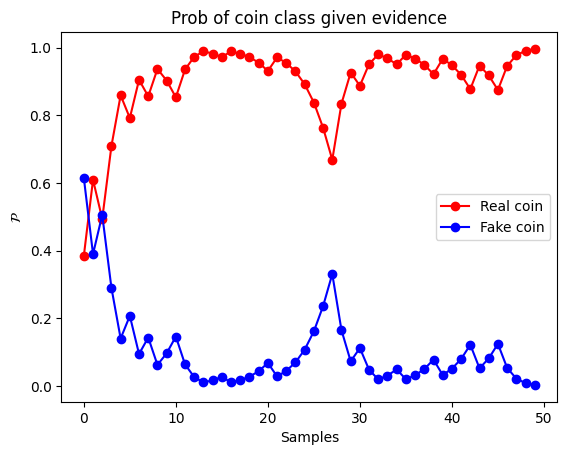

In [7]:
fig, ax = plt.subplots()

ax.plot(real_sample_prob, "ro-", label="Real coin")
ax.plot(fake_sample_prob, "bo-", label="Fake coin")
ax.set_ylabel(r"$\mathcal{P}$")
ax.set_title("Prob of coin class given evidence")
ax.set_xlabel("Samples")
plt.legend()
plt.show()

### Many coins

In [8]:
coins_head_prob = np.arange(1, 0 - 0.25, -0.25)
colors = "kbryg"

unknown_coin = get_random_coin(coins_head_prob)
print(unknown_coin)

N_samples = 50

coins_sample_prob = np.empty((N_samples, len(coins_head_prob)), dtype=np.float64)

for i in range(N_samples):
    sample = coin_flipper(unknown_coin)

    coins_sample_prob[i] = np.array([coin_prob(c, sample) for c in coins_head_prob], dtype=np.float64)

coins_sample_prob = np.cumprod(coins_sample_prob, axis=0)
Z = coins_sample_prob.sum(axis=1)
coins_sample_prob /= Z[:, np.newaxis]


0.75


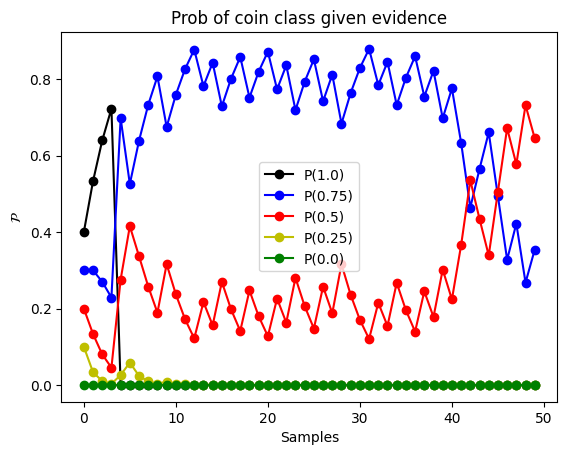

In [9]:
fig, ax = plt.subplots()

for i, c in enumerate(colors):
    ax.plot(coins_sample_prob[:, i], c + "o-", label=f"P({coins_head_prob[i]})")

ax.set_ylabel(r"$\mathcal{P}$")
ax.set_title("Prob of coin class given evidence")
ax.set_xlabel("Samples")
plt.legend()
plt.show()

### Readme Imgs

In [21]:
coins_head_prob = np.arange(1, 0 - 0.25, -0.25)
colors = "kbryg"

N_samples = 80

coins_sample_prob = np.empty((N_samples, len(coins_head_prob), len(coins_head_prob)), dtype=np.float64)

for j, coin in enumerate(coins_head_prob):

    for i in range(N_samples):
        sample = coin_flipper(coin)

        coins_sample_prob[i, :, j] = np.array([coin_prob(c, sample) for c in coins_head_prob], dtype=np.float64)

coins_sample_prob = np.cumprod(coins_sample_prob, axis=0)
Z = coins_sample_prob.sum(axis=1)
print(coins_sample_prob.shape, Z.shape)
coins_sample_prob /= Z[:, np.newaxis]

(80, 5, 5) (80, 5)


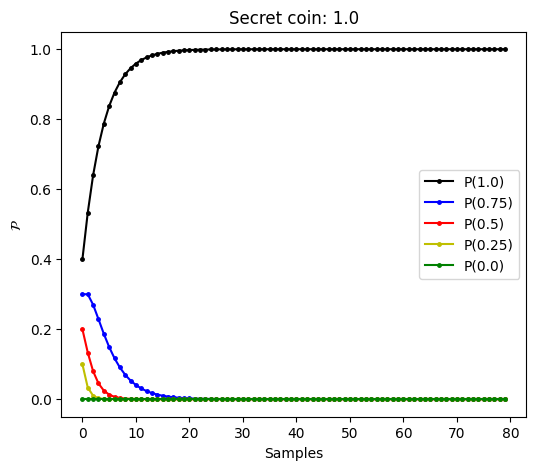

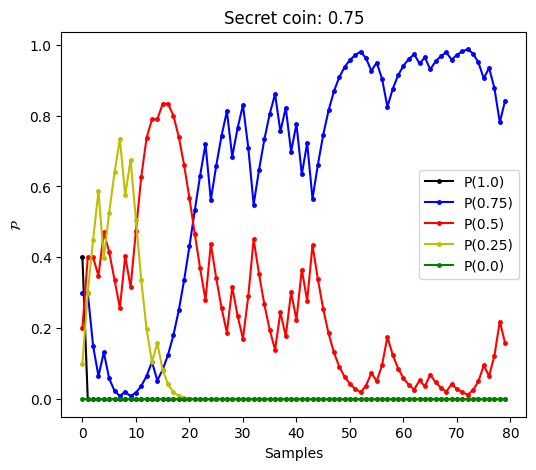

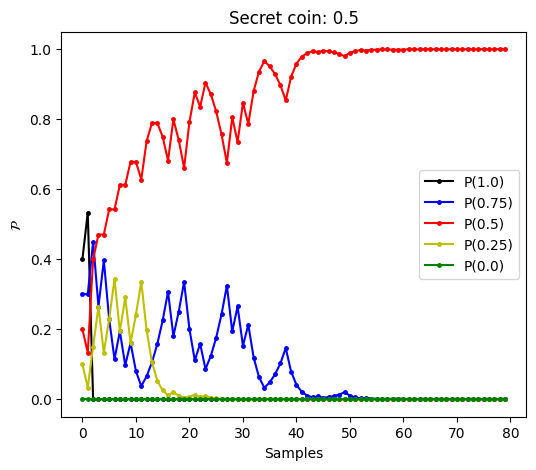

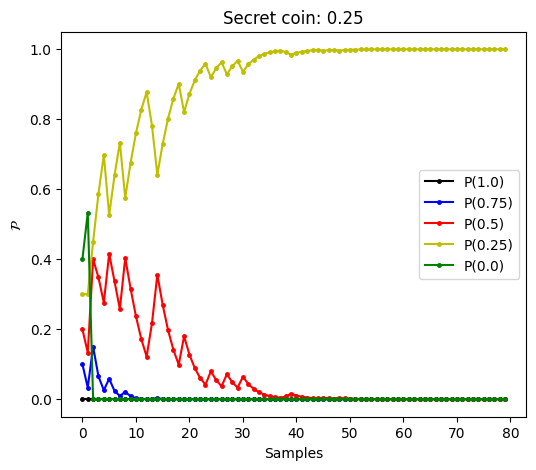

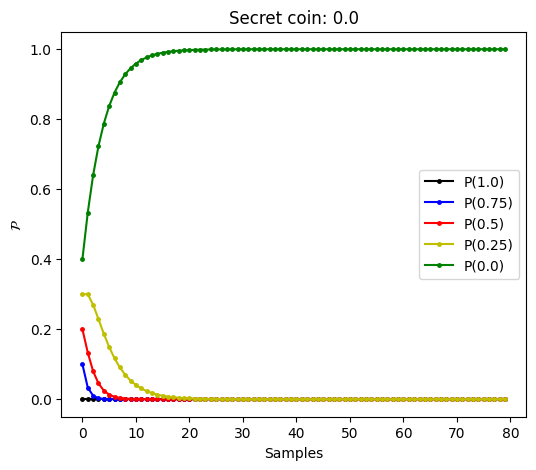

In [22]:
for j, secret_coin in enumerate(coins_head_prob):
    fig, ax = plt.subplots(figsize=(6, 5))

    for i, c in enumerate(colors):
        ax.plot(coins_sample_prob[:, i, j], c + "o-", markersize=2.5, label=f"P({coins_head_prob[i]})")

    ax.set_ylabel(r"$\mathcal{P}$")
    ax.set_title(f"Secret coin: {secret_coin}")
    ax.set_xlabel("Samples")
    plt.legend()
    plt.show()
    fig.savefig(f"images/bayesian_prob_{j}.png", dpi=100)